![](https://europe-west1-atp-views-tracker.cloudfunctions.net/working-analytics?notebook=tutorials--agent-rag-with-contextual--contextual-tutorial)
<img src="https://github.com/ContextualAI/examples/blob/main/images/Contextual_AI_Lockup_Dark.png?raw=true" alt="Image description" width="160" />

 # Building RAG Agents with Contextual AI 🚀
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NirDiamant/agents-towards-production/blob/main/tutorials/agent-RAG-with-Contextual/contextual_tutorial.ipynb)
 ## Streamline RAG Agent Creation for Your Documents

 Building Retrieval-Augmented Generation (RAG) systems for enterprise applications can be complex, involving infrastructure, chunking, and retrieval strategies. This tutorial demonstrates how to use **Contextual AI's managed platform** to simplify the process of building RAG agents, allowing you to focus on your use case rather than low-level details.

 ### Why This Matters

 Traditional RAG implementations face numerous challenges:
 - **Complex Infrastructure**: Setting up vector databases, embedding models, and retrieval systems
 - **Document Processing**: Handling diverse formats, tables, charts, and hierarchical content
 - **Hallucination Control**: Ensuring responses stay grounded in source documents
 - **Performance Evaluation**: Testing and optimizing retrieval accuracy and response quality

 Contextual AI offers a managed system designed to address these challenges and help you get started with RAG agents quickly.

## What You'll Build

In this hands-on tutorial, you'll create a **complete RAG agent for financial document analysis and quantitative reasoning**.

### Learning Outcomes
By completing this tutorial, you'll understand how to:
1. **Create and configure datastores** for document storage and indexing
2. **Ingest diverse document types** with accurate and hierarchy-aware parsing
3. **Build and deploy RAG agents** with custom instructions and safeguards
4. **Query and interact** with your agents through natural language
5. **Evaluate and optimize** agent performance using automated testing frameworks

⏱️ This tutorial can be run in under 15 minutes. All of these steps can also be performed via GUI for a no code RAG agent.

<div align="center">
<img src="https://github.com/user-attachments/assets/a0d8da57-b6b4-49d3-8a5a-4549b73b201c" alt="Contextual Architecture" width="1000"/>
</div>

---

## Environment Setup

First, we'll install the required dependencies and set up our development environment. The `contextual-client` library provides Python bindings for the Contextual AI platform, while the additional packages support data visualization and progress tracking.

In [ ]:
# Install required packages for Contextual AI integration and data visualization
%pip install contextual-client matplotlib tqdm requests pandas dotenv

Next, we'll import the necessary libraries that we'll use throughout this tutorial:

In [ ]:
import os
import json
import requests
from pathlib import Path
from typing import List, Optional, Dict
from IPython.display import display, JSON
import pandas as pd
from contextual import ContextualAI
import ast

---

##  Step 1: API Authentication Setup

### Getting Your Contextual AI API Key

Before we can start building our RAG agent, you'll need access to the Contextual AI platform.


### Step-by-Step API Key Setup:

1. **Create Your Account**: Visit [app.contextual.ai](https://app.contextual.ai/?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook) and click the **"Start Free"** button
2. **Navigate to API Keys**: Once logged in, find **"API Keys"** in the sidebar
3. **Generate New Key**: Click **"Create API Key"** and follow the setup steps
4. **Store Securely**: Copy your API key and store it safely (you won't be able to see it again)

<div align="center">
<img src="https://github.com/ContextualAI/examples/blob/main/images/API_Keys.png?raw=true" alt="API" width="800"/>


</div>

### Configuring Your API Key

To run this tutorial, you can store your API key in a `.env` file. This keeps your keys separate from your code. After setting up your .env file, you can load the API key from `.env` to initialize the Contextual AI client. Feel free to use Google Secrets as well if in Google Colab

Now, you can load the API key from `.env` to initialize the Contextual AI client.

In [ ]:
# Load API key from .env or google secrets
from dotenv import load_dotenv
import os
try:
    # Try Colab secrets if in Google Colab
    from google.colab import userdata
    API_KEY = userdata.get('CONTEXTUAL_API_KEY')
except:
    # Fallback to environment variable
    load_dotenv()
    API_KEY = os.getenv('CONTEXTUAL_API_KEY')

if not API_KEY:
    raise ValueError("Please set your CONTEXTUAL_API_KEY in Colab Secrets or as an environment variable")

from contextual import ContextualAI
client = ContextualAI(api_key=API_KEY)

---

##  Step 2: Create Your Document Datastore

### Understanding Datastores

A **datastore** in Contextual AI is a secure, isolated container for your documents and their processed representations. Each datastore provides:

- **🔒 Isolated Storage**: Documents are kept separate and secure for each use case
- **🧠 Intelligent Processing**: Automatic parsing, chunking, and indexing of uploaded documents
- **⚡ Optimized Retrieval**: High-performance search and ranking capabilities


### Why Separate Datastores?

Each agent should have its own datastore to ensure:
- **Data isolation** between different use cases
- **Security compliance** for sensitive document collections
- **Performance optimization** agents can be customized for specific document types and query patterns

Let's create a datastore for our financial document analysis agent:

In [ ]:
datastore_name = 'Financial_Demo_RAG'

# Check if datastore exists
datastores = client.datastores.list()
existing_datastore = next((ds for ds in datastores if ds.name == datastore_name), None)

if existing_datastore:
    datastore_id = existing_datastore.id
    print(f"Using existing datastore with ID: {datastore_id}")
else:
    result = client.datastores.create(name=datastore_name)
    datastore_id = result.id
    print(f"Created new datastore with ID: {datastore_id}")

---

##  Step 3: Document Ingestion and Processing

Now that your agent's datastore is set up, let's add some financial documents to it. Contextual AI's document processing engine provides **enterprise-grade parsing** that expertly handles:

- **📊 Complex Tables**: Financial data, spreadsheets, and structured information
- **📈 Charts and Graphs**: Visual data extraction and interpretation
- **📑 Multi-page Documents**: Long reports with hierarchical structure

### Supported File Formats

The platform supports a wide range of document formats:
- **PDF**: PDF documents
- **HTML**: Web pages and HTML documents
- **DOC/DOCX**: Microsoft Word documents
- **PPT/PPTX**: PowerPoint presentations

### Sample Financial Documents

For this tutorial, we'll use sample financial documents that demonstrate various challenging scenarios:
- **Quarterly revenue reports** with complex tabular information across several files
- **Data analysis documents** with comparative data
- **Statistical reports** with charts and metrics

Let's prepare our document collection:

In [ ]:
import os
import requests

# Create data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# File list with corresponding GitHub URLs
files_to_upload = [
    # NVIDIA quarterly revnue 24/25
    ("A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf"),
    # NVIDIA quarterly revenue 22/23
    ("B_Q423-Qtrly-Revenue-by-Market-slide.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/B_Q423-Qtrly-Revenue-by-Market-slide.pdf"),
    # Spurious correlations report - fun example of graphs and statistical analysis
    ("C_Neptune.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/C_Neptune.pdf"),
    # Another spurious correlations report - fun example of graphs and statistical analysis
    ("D_Unilever.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/D_Unilever.pdf")
]

### Document Download and Ingestion Process

The following cell will:
1. **Download documents** from Contextual AI's examples repository (if not already cached)
2. **Upload to Contextual AI** for intelligent processing
3. **Track processing status** and document IDs for later reference

In [ ]:
# Download and ingest all files
document_ids = []
for filename, url in files_to_upload:
    file_path = f'data/{filename}'

    # Download file if it doesn't exist
    if not os.path.exists(file_path):
        print(f"Fetching {file_path}")
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for bad status codes
            with open(file_path, 'wb') as f:
                f.write(response.content)
        except Exception as e:
            print(f"Error downloading {filename}: {str(e)}")
            continue

    # Upload to datastore
    try:
        with open(file_path, 'rb') as f:
            ingestion_result = client.datastores.documents.ingest(datastore_id, file=f)
            document_id = ingestion_result.id
            document_ids.append(document_id)
            print(f"Successfully uploaded {filename} to datastore {datastore_id}")
    except Exception as e:
        print(f"Error uploading {filename}: {str(e)}")

print(f"Successfully uploaded {len(document_ids)} files to datastore")
print(f"Document IDs: {document_ids}")

### Inspect Documents

Let's take a look at our documents at [https://app.contextual.ai/](https://app.contextual.ai/?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook)

1. Navigate to your workspace  
2. Select **Datastores** on the left menu  
3. Select **Documents**  
4. Click on **Inspect** (once documents load)

You will see datastore uploads in progress:


Once ingested, you can view the list of documents, see their metadata, and also delete documents via API.

**Note:** It may take a few minutes for the document to be ingested and processed. If the documents are still being ingested, you will see `status='processing'`. Once ingestion is complete, the status will show as `status='completed'`.

You can learn more about the metadata [here](https://docs.contextual.ai/api-reference/datastores-documents/get-document-metadata?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook).

In [ ]:
metadata = client.datastores.documents.metadata(datastore_id = datastore_id, document_id = document_ids[0])
print("Document metadata:", metadata)

---

##  Step 4: Agent Creation and Configuration

Now you'll create our RAG agent that will interact with the documents you just ingested.

You can customize the Agent using additional parameters such as:

- **`system_prompt`** is used for the instructions that your RAG system references when generating responses. Note that this is the default prompt as of 8.18.25.
- **`suggested_queries`** is a user experience feature, to prepopulate queries for the agent so a new user can see interesting examples.  

Optional: You can also configure or edit your agent in the UI at [app.contextual.ai](https://app.contextual.ai/?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook), try changing the generation model to another LLM!  

You can find all the additional parameters [here](https://docs.contextual.ai/api-reference/agents/create-agent?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook)

In [ ]:
system_prompt = '''
You are a helpful AI assistant created by Contextual AI to answer questions about relevant documentation provided to you. Your responses should be precise, accurate, and sourced exclusively from the provided information. Please follow these guidelines:
* Only use information from the provided documentation. Avoid opinions, speculation, or assumptions.
* Use the exact terminology and descriptions found in the provided content.
* Keep answers concise and relevant to the user's question.
* Use acronyms and abbreviations exactly as they appear in the documentation or query.
* Apply markdown if your response includes lists, tables, or code.
* Directly answer the question, then STOP. Avoid additional explanations unless specifically relevant.
* If the information is irrelevant, simply respond that you don't have relevant documentation and do not provide additional comments or suggestions. Ignore anything that cannot be used to directly answer this query.
'''

agent_name = "Demo"

# Get list of existing agents
agents = client.agents.list()

# Check if agent already exists
existing_agent = next((agent for agent in agents if agent.name == agent_name), None)

if existing_agent:
    agent_id = existing_agent.id
    print(f"Using existing agent with ID: {agent_id}")
else:
    print("Creating new agent")
    app_response = client.agents.create(
        name=agent_name,
        description="Helpful Grounded AI Assistant",
        datastore_ids=[datastore_id],
        agent_configs={
        "global_config": {
            "enable_multi_turn": False # Turning this off for deterministic responses for this demo
        }
        },
        suggested_queries=[
            "What was NVIDIA's annual revenue by fiscal year 2022 to 2025?",
            "When did NVIDIA's data center revenue overtake gaming revenue?",
            "What's the correlation between the distance between Neptune and the Sun and Burglary rates in the US?",
            "What's the correlation between Global revenue generated by Unilever Group and Google searches for 'lost my wallet'?",
            "Does this imply that Unilever Group's revenue is derived from lost wallets?",
            "What's the correlation between the distance between Neptune and the Sun and Global revenue generated by Unilever Group?"
        ]
    )
    agent_id = app_response.id
    print(f"Agent ID created: {agent_id}")

### Let's look at our Agent in the Platform

Visit: [https://app.contextual.ai/](https://app.contextual.ai/?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook)

1. Navigate to your workspace  
2. Select **Agents** from the left menu  
3. Select your Agent  
4. Try a suggested query or type your question  


---

##  Step 5: Query the Agent

### Testing Your RAG Agent

Now that our agent is configured and connected to our financial documents, let's test its capabilities with various types of queries.

The required fields are:

- **`agent_id`**: The unique identifier of your Agent  
- **`messages`**: A list of message(s) forming the user query  

Optional information includes parameters for `stream` and `conversation_id`. You can refer [here](https://docs.contextual.ai/api-reference/agents-query/query) for more information.

Let's try this query: **"What was NVIDIA's annual revenue by fiscal year 2022 to 2025?"**queries:

In [ ]:
query_result = client.agents.query.create(
    agent_id=agent_id,
    messages=[{
        "content": "What was NVIDIA's annual revenue by fiscal year 2022 to 2025?",
        "role": "user"
    }]
)
print(query_result.message.content)

Based on the provided documentation, I can present NVIDIA's annual revenue for fiscal years 2022 through 2025. Here are the total annual figures derived from the quarterly data:

For Fiscal Year 2022, the total annual revenue was $7,643 million in Q4, $7,103 million in Q3, $6,507 million in Q2, and $5,661 million in Q1.[2]()()

For Fiscal Year 2023, the quarterly revenues were $6,051 million in Q4, $5,931 million in Q3, $6,704 million in Q2, and $8,288 million in Q1.[2]()()

For Fiscal Year 2024, the quarterly figures showed $22,103 million in Q4, $18,120 million in Q3, $13,507 million in Q2, and $7,192 million in Q1.[1]()()

For Fiscal Year 2025, the quarterly revenues were $39,331 million in Q4, $35,082 million in Q3, $30,040 million in Q2, and $26,044 million in Q1.[1]()()

These figures demonstrate a clear upward trend in NVIDIA's annual revenue across the specified fiscal years.


There is lots more information you can access from the query result. You can display the retrieved documents, for example.   


--- Processing Document 1 ---
Retrieval Info for Document 1:


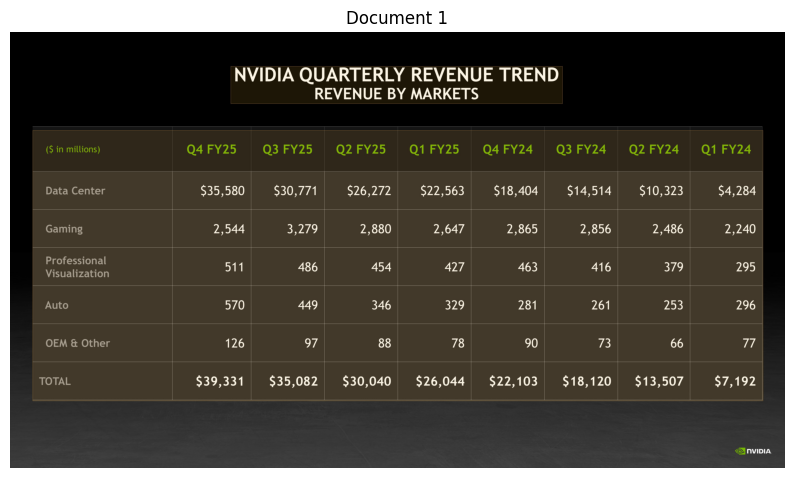


--- Processing Document 2 ---
Retrieval Info for Document 2:


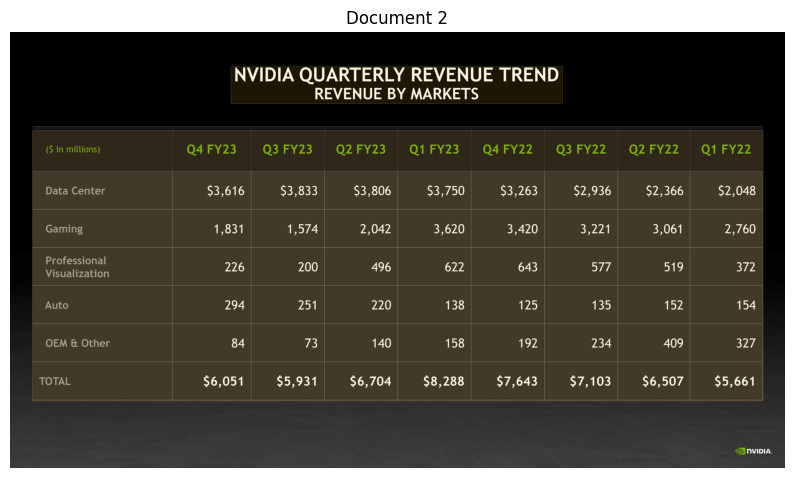


Total documents processed: 2


In [ ]:
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt

def display_base64_image(base64_string, title="Document"):
    # Decode base64 string
    img_data = base64.b64decode(base64_string)

    # Create PIL Image object
    img = Image.open(io.BytesIO(img_data))

    # Display using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

    return img

# Retrieve and display all referenced documents
for i, retrieval_content in enumerate(query_result.retrieval_contents):
    print(f"\n--- Processing Document {i+1} ---")

    # Get retrieval info for this document
    ret_result = client.agents.query.retrieval_info(
        message_id=query_result.message_id,
        agent_id=agent_id,
        content_ids=[retrieval_content.content_id]
    )

    print(f"Retrieval Info for Document {i+1}:")

    # Display the document image
    if ret_result.content_metadatas and ret_result.content_metadatas[0].page_img:
        base64_string = ret_result.content_metadatas[0].page_img
        img = display_base64_image(base64_string, f"Document {i+1}")
    else:
        print(f"No image available for Document {i+1}")

print(f"\nTotal documents processed: {len(query_result.retrieval_contents)}")

### Key Observations from Agent Testing

Our RAG agent demonstrates several important capabilities:

✅ **Accurate Data Extraction**: Finds specific numerical data and provides exact figures with citations

✅ **Source Attribution**: Includes inline citations linking responses back to source documents


---

##  Step 6: Evaluate your Agent

### Understanding LMUnit Testing Framework

To ensure our RAG agent performs reliably in production, we need systematic evaluation beyond manual testing. Contextual AI provides **LMUnit** - a natural language testing framework that evaluates RAG systems across multiple dimensions.

For more details, check out the [blog post](https://contextual.ai/blog/lmunit/?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook) and the [full notebook](https://github.com/ContextualAI/examples/blob/main/03-standalone-api/01-lmunit/lmunit.ipynb?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook)

### Why Automated Evaluation Matters

Manual testing alone isn't sufficient for production RAG systems.
**Natural Language Unit Testing** enables you to:

- Break down evaluation into specific, testable criteria  
- Get granular feedback on various quality aspects  
- Drive systematic improvements in LLM outputs  
- Support domain-specific quality standards  



For this example, we will use global unit tests that we will run across all our responses. The following were six critical dimensions for quantitative reasoning we chose as unit tests:

1. **Accuracy**  
   - *Question:* "Does the response accurately extract specific numerical data from the documents?"  
   - *Why:* Ensures responses correctly identify and use quantitative information  

2. **Causation**  
   - *Question:* "Does the agent properly distinguish between correlation and causation?"  
   - *Why:* Tests whether analytical reasoning is sound and avoids logical fallacies  

3. **Synthesis**  
   - *Question:* "Are multi-document comparisons performed correctly with accurate calculations?"  
   - *Why:* Validates ability to synthesize information across sources  

4. **Limitations**  
   - *Question:* "Are potential limitations or uncertainties in the data clearly acknowledged?"  
   - *Why:* Ensures appropriate caveats and transparency  

5. **Evidence**  
   - *Question:* "Are quantitative claims properly supported with specific evidence from the source documents?"  
   - *Why:* Tests whether conclusions are properly grounded in source material  

6. **Relevance**  
   - *Question:* "Does the response avoid unnecessary information?"  
   - *Why:* Verifies responses stay focused and concise  


Here are the unit tests we are going to run to ascertain how our system performs:

In [ ]:
unit_tests = [
      "Does the response accurately extract specific numerical data from the documents?",
      "Does the agent properly distinguish between correlation and causation?",
      "Are multi-document comparisons performed correctly with accurate calculations?",
      "Are potential limitations or uncertainties in the data clearly acknowledged?",
      "Are quantitative claims properly supported with specific evidence from the source documents?",
      "Does the response avoid unnecessary information?"
]

LMUnit is specifically trained for evaluating natural language unit tests and provides:

* Scores on a continuous 1-5 scale
* Consistent evaluation across different criteria
* Better performance than general-purpose LLMs
* Ability to add rubrics to evaluation

Let's start with a simple example to understand how LMUnit works:

In [ ]:
response = client.lmunit.create(
                    query="What was NVIDIA's Data Center revenue in Q4 FY25?",
                   response = """NVIDIA's Data Center revenue for Q4 FY25 was $35,580 million.\[1\]()

                                This represents a significant increase from the previous quarter (Q3 FY25) when Data Center revenue was $30,771 million.[1]()

                                The full quarterly trend for Data Center revenue in FY25 was:
                                - Q4 FY25: $35,580 million
                                - Q3 FY25: $30,771 million
                                - Q2 FY25: $26,272 million
                                - Q1 FY25: $22,563 million[1]()
                              """,
                    unit_test="Does the response avoid unnecessary information?"
                )
print(response)

LMUnitCreateResponse(score=2.338)


The response **did** include unnecessary information! Later we can tweak our prompt to better fit this requirement.

Let's begin with creating an evaluation dataset with 6 queries. This dataset is generated by asking our RAG Agent the listed queries and saving the generated responses for evaluation.

In [ ]:
# RAG Evaluation Questions
queries = [
   "What was NVIDIA's Data Center revenue in Q4 FY25?",
   "What is the correlation coefficient between Neptune's distance from the Sun and US burglary rates?",
   "How did NVIDIA's total revenue change from Q1 FY22 to Q4 FY25?",
   "What are the four main reasons why spurious correlations work, according to the Tyler Vigen documents?",
   "Why should we be skeptical of the correlation between Unilever's revenue and Google searches for 'lost my wallet'?",
   "When did NVIDIA's data center revenue overtake gaming revenue?"
]

# Create DataFrame from questions
eval = pd.DataFrame({'prompt': queries})
eval['response'] = ''

# Query the agent for each question
for index, row in eval.iterrows():
   try:
       query_result = client.agents.query.create(
           agent_id=agent_id,
           messages=[{
               "content": row['prompt'],
               "role": "user"
           }]
       )
       eval.at[index, 'response'] = query_result.message.content
   except Exception as e:
       print(f"Error processing row {index}: {e}")
       eval.at[index, 'response'] = f"Error: {e}"

print(eval[['prompt', 'response']])
# prompt: save eval as csv

eval.to_csv('eval_input.csv', index=False)

                                              prompt  \
0  What was NVIDIA's Data Center revenue in Q4 FY25?   
1  What is the correlation coefficient between Ne...   
2  How did NVIDIA's total revenue change from Q1 ...   
3  What are the four main reasons why spurious co...   
4  Why should we be skeptical of the correlation ...   
5  When did NVIDIA's data center revenue overtake...   

                                            response  
0  According to the provided NVIDIA quarterly rev...  
1  Based on the provided documentation, I can dir...  
2  Based on the provided documentation, I can pre...  
3  According to Tyler Vigen's documentation, ther...  
4  As a careful analysis of the provided document...  
5  Based on the provided financial data, I can pr...  


Now let's test the full batch:

In [ ]:
def run_unit_tests_with_progress(
    df: pd.DataFrame,
    unit_tests: List[str],
    batch_size: int = 10
) -> List[Dict]:
    """
    Run unit tests with progress tracking and error handling.

    Args:
        df: DataFrame with prompt-response pairs
        unit_tests: List of unit test strings
        batch_size: Number of tests to run in parallel

    Returns:
        List of test results
    """
    results = []

    # Iterate over the DataFrame rows
    for idx in tqdm(range(0, len(df)), desc="Processing responses"):
        row = df.iloc[idx]
        row_results = []

        # Run each unit test on the current prompt-response pair
        for test in unit_tests:
            try:
                result = client.lmunit.create(
                    query=row['prompt'],
                    response=row['response'],
                    unit_test=test
                )

                # Collect the test result score and metadata if available
                row_results.append({
                    'test': test,
                    'score': result.score,
                    'metadata': result.metadata if hasattr(result, 'metadata') else None
                })

            except Exception as e:
                print(f"Error with prompt {idx}, test '{test}': {e}")
                row_results.append({
                    'test': test,
                    'score': None,
                    'error': str(e)
                })

        # Store results
        results.append({
            'prompt': row['prompt'],
            'response': row['response'],
            'test_results': row_results
        })

    return results

from tqdm import tqdm
results = run_unit_tests_with_progress(eval, unit_tests)

pd.DataFrame([(r['prompt'], r['response'], t['test'], t['score']) for r in results for t in r['test_results']], columns=['prompt', 'response', 'test', 'score']).to_csv(f"unit_test_results.csv", index=False)
df = pd.read_csv("unit_test_results.csv")

for result in results[:2]:  # Slice to get the first two entries
    print(f"\nPrompt: {result['prompt']}")
    print(f"Response: {result['response']}")
    print("Test Results:")
    for test_result in result['test_results']:
        print(f"- {test_result['test']}: {test_result['score']}")

Now, we can visualize the metrics with polar plots. Polar plots (also called radar charts or spider plots) are particularly useful for visualizing multidimensional scores because they excel at showing patterns and trade-offs across several related metrics simultaneously

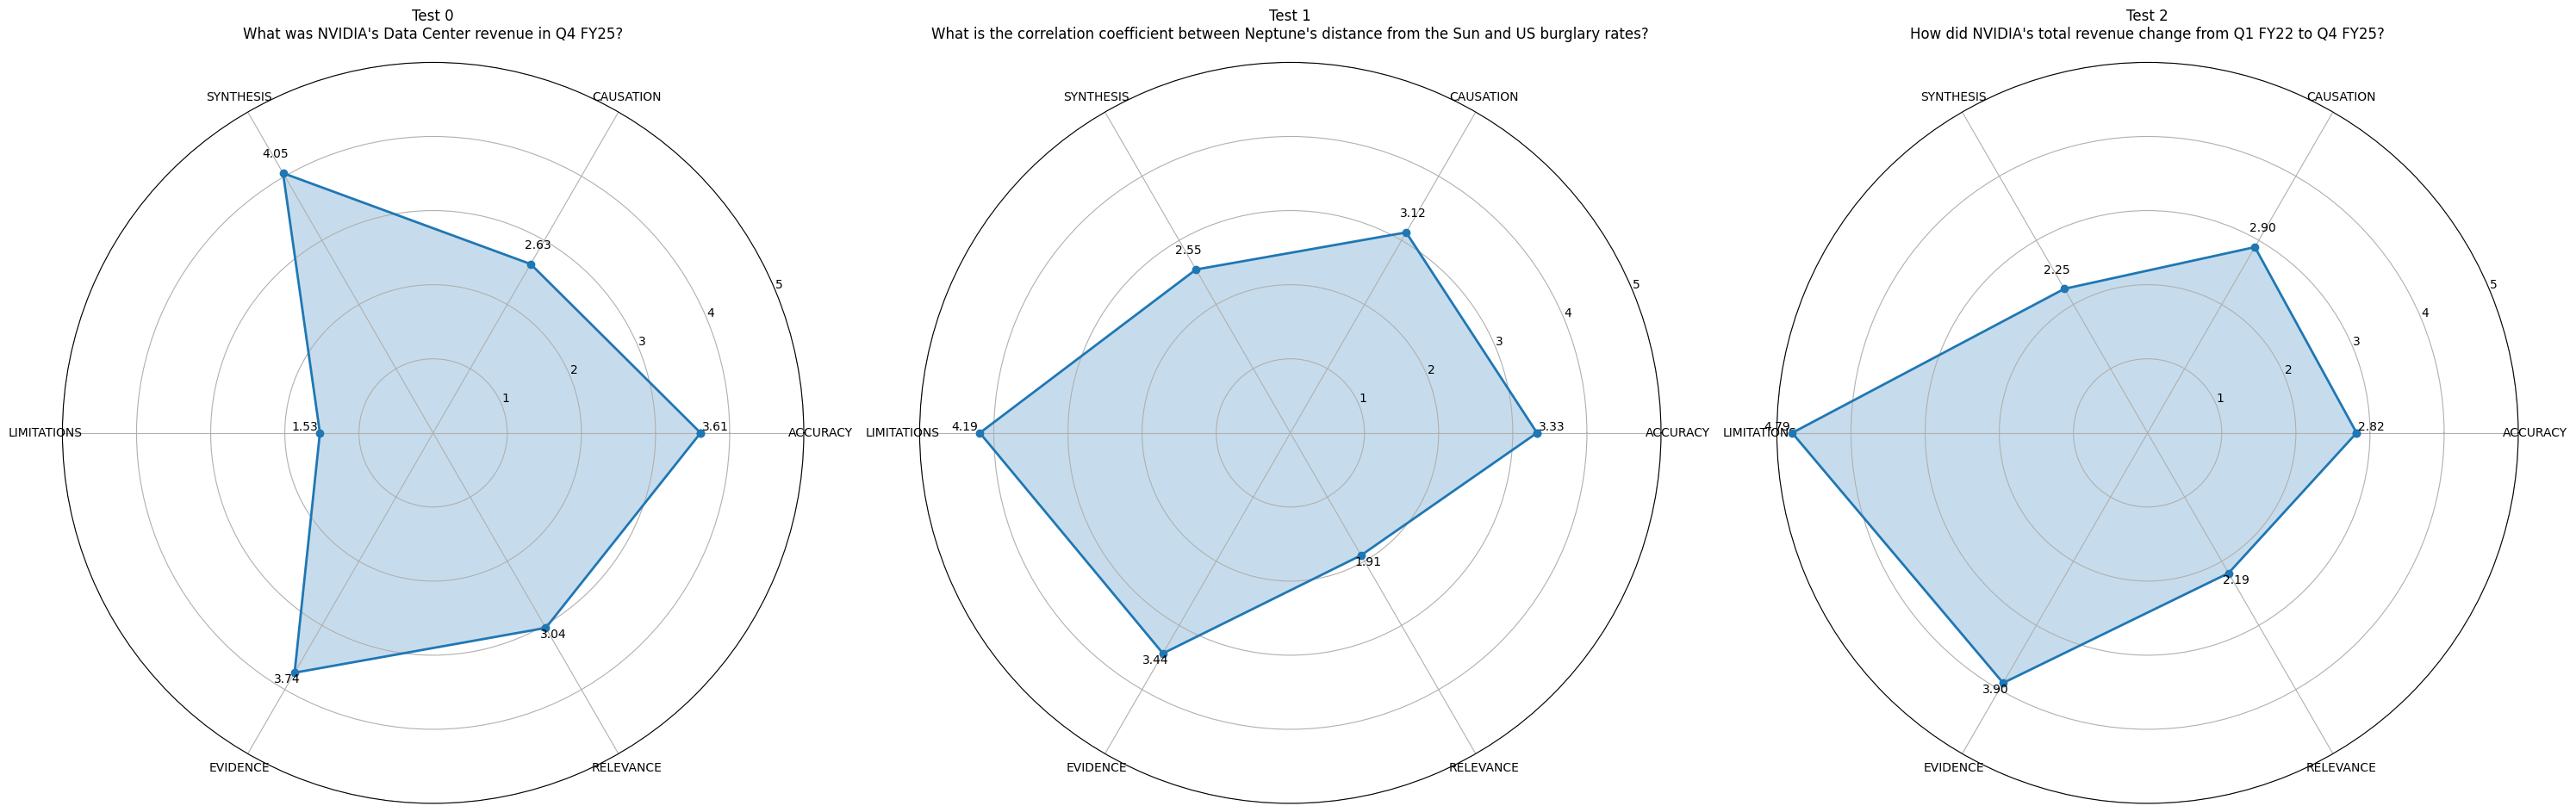

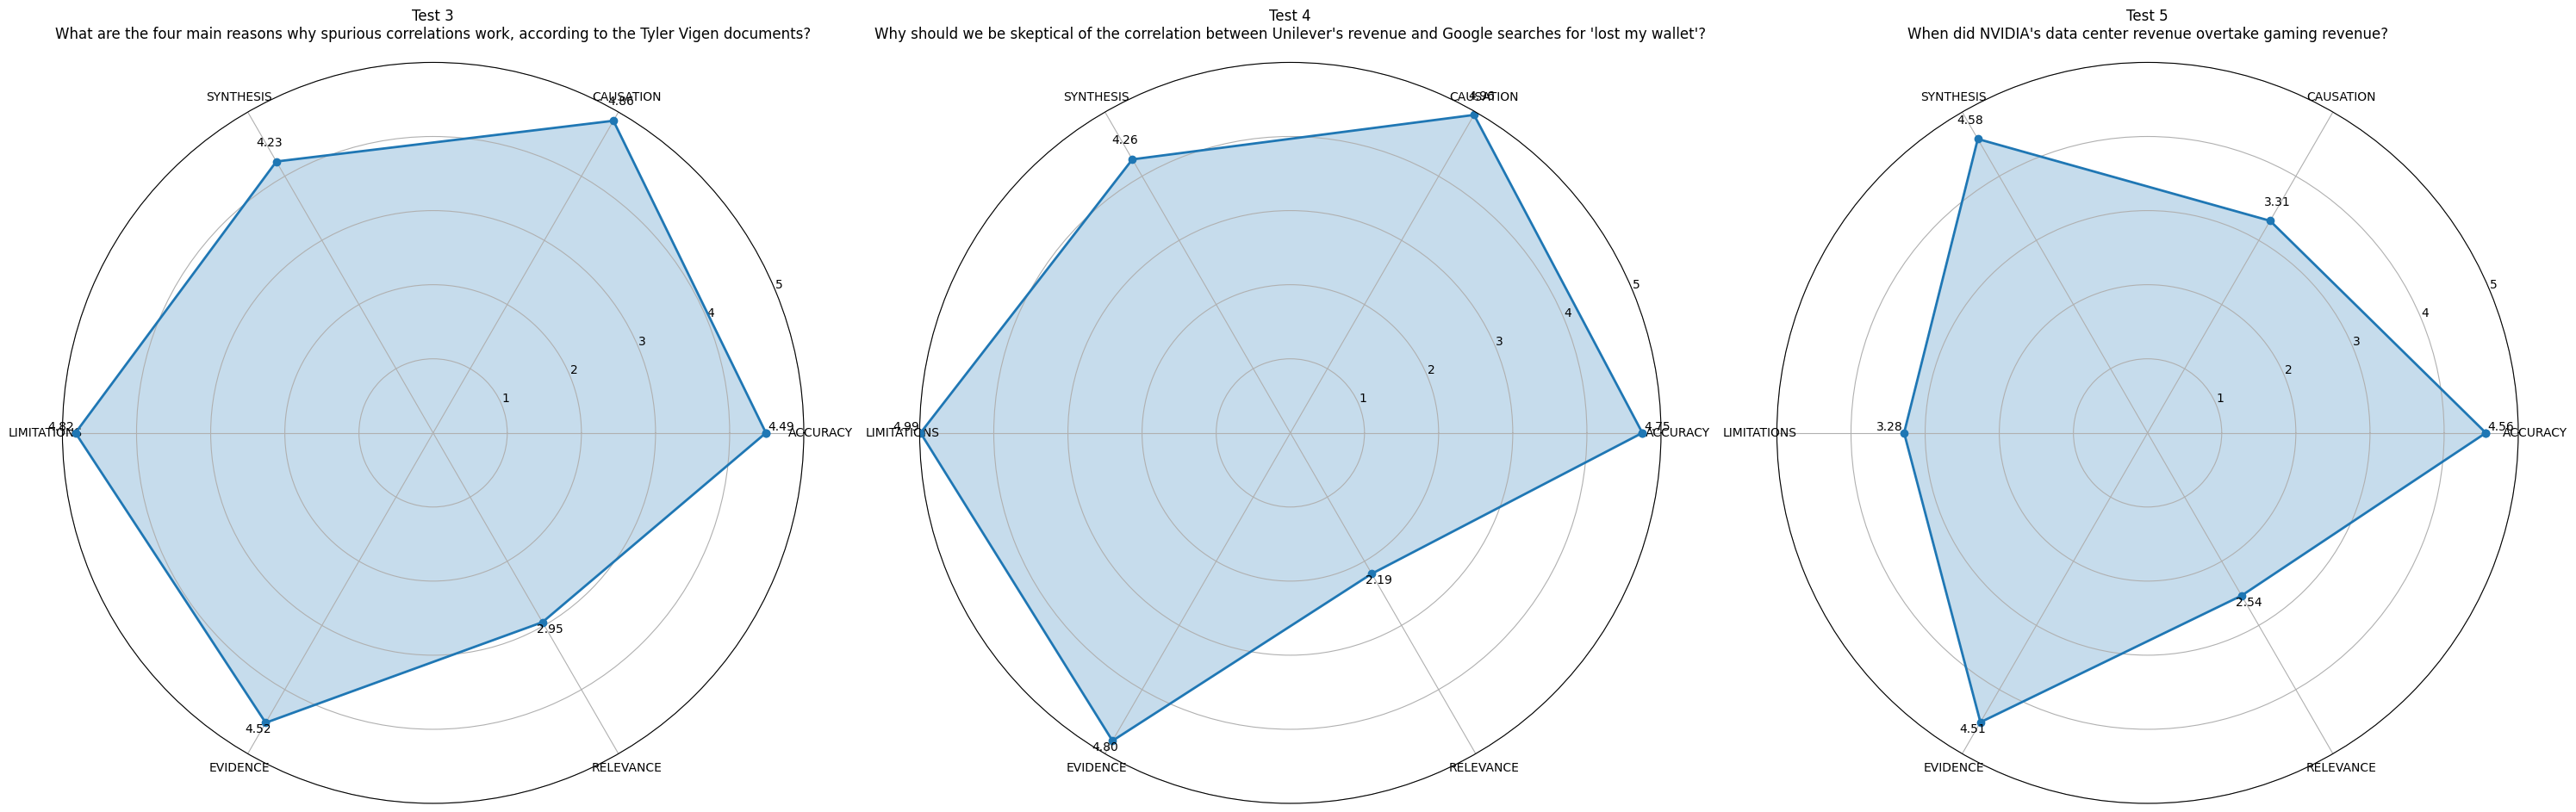

In [ ]:
# For polar plots
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Tuple

#clustering analysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

def map_test_to_category(test_question: str) -> str:
    """Map the full test question to its category."""
    category_mapping = {
        'Does the response accurately extract specific numerical data': 'ACCURACY',
        'Does the agent properly distinguish between correlation and causation': 'CAUSATION',
        'Are multi-document comparisons performed correctly': 'SYNTHESIS',
        'Are potential limitations or uncertainties in the data': 'LIMITATIONS',
        'Are quantitative claims properly supported with specific evidence': 'EVIDENCE',
        'Does the response avoid unnecessary information': 'RELEVANCE'
    }

    for key, value in category_mapping.items():
        if key.lower() in test_question.lower():
            return value
    return None

def create_unit_test_plots(results: List[Dict],
                          test_indices: Optional[Union[int, List[int]]] = None,
                          figsize: tuple = (10, 10)):
    """
    Create polar plot(s) for unit test results. Can plot either a single test,
    specific multiple tests, or all tests in a row.

    Args:
        results: List of dictionaries containing test results
        test_indices: Optional; Either:
            - None (plots all results)
            - int (plots single result)
            - List[int] (plots multiple specific results)
        figsize: Tuple specifying the figure size (width, height)
    """
    # Handle different input cases for test_indices
    if test_indices is None:
        indices_to_plot = list(range(len(results)))
    elif isinstance(test_indices, int):
        if test_indices >= len(results):
            raise IndexError(f"test_index {test_indices} is out of range. Only {len(results)} results available.")
        indices_to_plot = [test_indices]
    else:
        if not test_indices:
            raise ValueError("test_indices list cannot be empty")
        if max(test_indices) >= len(results):
            raise IndexError(f"test_index {max(test_indices)} is out of range. Only {len(results)} results available.")
        indices_to_plot = test_indices

    # Categories in desired order
    categories = ['ACCURACY', 'CAUSATION', 'SYNTHESIS',
                'LIMITATIONS', 'EVIDENCE', 'RELEVANCE']

    # Set up the angles for the polar plot
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Close the plot

    # Calculate figure size based on number of plots
    num_plots = len(indices_to_plot)
    fig_width = figsize[0] * num_plots
    fig = plt.figure(figsize=(fig_width, figsize[1]))

    # Create a subplot for each result
    for plot_idx, result_idx in enumerate(indices_to_plot):
        result = results[result_idx]

        # Create subplot
        ax = plt.subplot(1, num_plots, plot_idx + 1, projection='polar')

        # Get scores for this result
        scores = []
        for category in categories:
            score = None
            for test_result in result['test_results']:
                mapped_category = map_test_to_category(test_result['test'])
                if mapped_category == category:
                    score = test_result['score']
                    break
            scores.append(score if score is not None else 0)

        # Close the scores array
        scores = np.concatenate((scores, [scores[0]]))

        # Plot the scores
        ax.plot(angles, scores, 'o-', linewidth=2)
        ax.fill(angles, scores, alpha=0.25)

        # Set the labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)

        # Set the scale
        ax.set_ylim(0, 5)

        # Add grid
        ax.grid(True)

        # Add score values as annotations
        for angle, score, category in zip(angles[:-1], scores[:-1], categories):
            ax.text(angle, score + 0.2, f'{score:.2f}',
                    ha='center', va='bottom')

        # Add title for each subplot
        prompt = result['prompt']
        ax.set_title(f"Test {result_idx}\n{prompt}", pad=20)

    plt.tight_layout()
    return fig

# Plot the test results
fig = create_unit_test_plots(results, test_indices=[0, 1, 2])
fig = create_unit_test_plots(results, test_indices=[3, 4, 5])